In [393]:
import pandas as pd
import sys, numpy as np
sys.path.append("/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/")
import caffe
import lmdb


# location of the list that was used to create LMDB for training/testing
test_list = '../../data/allFrames/lists/shuffle_sampled_test_list.txt'

N = 7840 # the number of test examples
num_classes = 101 # the number of classes

# Get the labels from the list

In [394]:
def get_label_from_list(list_filename):
    df = pd.read_csv(list_filename, delimiter= ' ', header = None, names = ['filename', 'class_id'])
    return df

df =  get_label_from_list(test_list)
labels = df.class_id.values
df['video_name'] = df.filename.apply(lambda x: x.split('/')[0])

# Map the video to the labels

In [448]:
# map the videos to the labels
video_to_labels = list(set(zip(df.video_name, df.class_id)))
video_to_labels = pd.DataFrame(data=[l[1] for l in video_to_labels], index=[l[0] for l in video_to_labels], columns=['true_labels'])

# Extract features using the extract_features binary

In [195]:
!./extract.sh 

E0306 18:16:05.343775 16268 extract_features.cpp:54] Using GPU
E0306 18:16:05.344267 16268 extract_features.cpp:60] Using Device_id=2
E0306 18:16:06.052824 16268 upgrade_proto.cpp:618] Attempting to upgrade input file specified using deprecated V1LayerParameter: ./quick_train_test.prototxt
E0306 18:16:09.663082 16268 extract_features.cpp:134] Extacting Features
E0306 18:16:19.302606 16268 extract_features.cpp:169] Extracted features of 1000 query images for feature blob fc8_allFrames
E0306 18:16:28.962952 16268 extract_features.cpp:169] Extracted features of 2000 query images for feature blob fc8_allFrames
E0306 18:16:38.564700 16268 extract_features.cpp:169] Extracted features of 3000 query images for feature blob fc8_allFrames
E0306 18:16:48.179500 16268 extract_features.cpp:169] Extracted features of 4000 query images for feature blob fc8_allFrames
E0306 18:16:57.882446 16268 extract_features.cpp:169] Extracted features of 5000 query images for feature blob fc8_allFrames
E0306 18:17

## Open and extract the data from the LMDB

In [459]:
env = lmdb.open('/afs/cs.stanford.edu/u/anenberg/scr/CS231N/examples/allFrames_finetune/extracted/test_features/', readonly=True)

predicted_labels = [] # for a particular image, this will be the argmax for the scores
data = np.zeros((N, num_classes)) # collect the scores for each image for each class

with env.begin() as txn:
    with txn.cursor() as cursor:
        for i in range(N):
            key = str(i)
            val = cursor.get(key)
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(val)
            # datum.ListFields()[3][1] contains the scores
            data[i, :] = np.array(list(datum.ListFields()[3][1]))
            predicted_labels.append(np.argmax(np.array(list(datum.ListFields()[3][1]))))


# create the normalized dataframe

In [460]:
normalized_data = np.exp(data)/sum(np.exp(data))
normalized_data = pd.DataFrame(normalized_data)

# average the probabilities across videos

In [465]:
normalized_data['video_name'] = df['video_name']
normalized_data = normalized_data.groupby('video_name').mean()
normalized_data['predicted_label'] = np.argmax(normalized_data.values, axis = 1)
normalized_data['true_label'] = video_to_labels

# Compute the average precision

In [462]:
def compute_average_precision(normalized_data, class_id):
    # given a class_id compute the average precision for that class
    df = normalized_data[[class_id, 'true_label', 'predicted_label']]
    df = df.sort(class_id, ascending=False)
    df['match'] = (df.true_label == class_id)
    df['precision'] = np.cumsum(df.match)/np.arange(1, len(normalized_data) + 1)
    df['recall'] = np.cumsum(df.match)/np.sum(df.true_label == class_id)
    df['delta_recall'] = np.diff(np.append([0], df.recall.values))
    df['rect_area'] = df['precision'] * df['delta_recall']
    return sum(df.rect_area)

average_precision = [] # list to hold average_precision

for class_id in range(num_classes):
    ca = compute_average_precision(normalized_data, class_id)
    average_precision.append(ca)

In [464]:
normalized_datad

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,video_name,predicted_label,true_label
0,1.041090e-21,1.531660e-19,4.451371e-18,1.051879e-19,4.240376e-20,3.948032e-20,1.282439e-16,4.097971e-20,1.585814e-18,4.445506e-20,...,3.124966e-20,7.020204e-20,8.209167e-19,1.189350e-17,6.956419e-20,7.401604e-20,1.130238e-19,video_test_0000113,101,NaN
1,5.177502e-20,2.848251e-20,2.551352e-19,8.456904e-23,6.028907e-16,1.252916e-19,2.367275e-18,1.201995e-18,6.280585e-19,2.356700e-19,...,3.164270e-20,3.795679e-19,4.709657e-19,1.112589e-20,7.671352e-19,6.104059e-20,2.364337e-16,video_test_0001007,101,NaN
2,8.054758e-18,2.515421e-18,3.377190e-19,4.528318e-17,5.462805e-22,4.062337e-19,1.157206e-19,1.964422e-19,1.119809e-19,1.714064e-18,...,1.851774e-18,3.856289e-21,2.257426e-20,2.543104e-20,9.756898e-21,1.704867e-20,2.683351e-21,video_test_0001465,101,NaN
3,4.497883e-21,1.838578e-21,2.213131e-20,5.080992e-22,4.219514e-17,1.087430e-19,3.233786e-20,3.117848e-17,2.190561e-17,1.612342e-18,...,5.519434e-20,4.091490e-15,3.643561e-16,3.695984e-21,9.002887e-20,2.981207e-19,8.070927e-20,video_test_0000926,101,NaN
4,2.801940e-22,1.715256e-19,3.856970e-19,5.912351e-17,7.420986e-15,5.751207e-21,6.215105e-20,3.108001e-21,1.064019e-16,6.591510e-20,...,3.143143e-18,2.728383e-17,1.744768e-18,3.138278e-20,2.903168e-18,3.156472e-19,1.409221e-20,video_test_0000832,101,NaN
5,1.155647e-17,6.084151e-18,4.851892e-19,3.231295e-16,1.137440e-21,3.187473e-20,4.325188e-21,8.585401e-20,4.379138e-19,7.964947e-19,...,2.512370e-18,2.675786e-21,2.922513e-19,1.896233e-20,2.761518e-18,7.135716e-18,2.129645e-20,video_test_0001149,101,NaN
6,1.123960e-17,1.891141e-17,6.432088e-21,7.221654e-19,1.960152e-19,2.905428e-22,2.830275e-20,1.650822e-19,8.802455e-20,3.139790e-19,...,2.530203e-18,7.821662e-21,3.938821e-17,3.402861e-21,2.032348e-17,1.354732e-18,1.541123e-19,video_test_0000592,101,NaN
7,2.538321e-19,1.425071e-19,1.163019e-19,1.314135e-20,5.554621e-20,4.835441e-20,2.652220e-20,3.102937e-20,2.352261e-18,2.626873e-18,...,4.347803e-20,4.553110e-21,4.963807e-19,2.604783e-19,1.015231e-20,3.037608e-21,3.286348e-20,video_test_0000514,101,NaN
8,5.544823e-19,1.125537e-19,1.538336e-18,1.178484e-19,2.362672e-20,3.927389e-20,4.829326e-19,6.149739e-19,4.928417e-20,2.185743e-18,...,2.338354e-18,3.435965e-21,4.907785e-18,5.489249e-17,4.658856e-17,6.260195e-20,1.218708e-18,video_test_0001530,101,NaN
9,1.703382e-19,2.091440e-19,1.000111e-19,2.545766e-18,6.909570e-20,1.181722e-19,2.179865e-19,1.336383e-19,1.006294e-19,2.066545e-19,...,1.059454e-18,2.006986e-19,2.380858e-18,1.239414e-19,3.930132e-19,6.121021e-20,8.122535e-20,video_test_0001546,101,NaN


Populating the interactive namespace from numpy and matplotlib


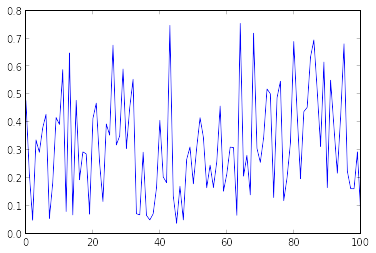

In [449]:
%pylab inline
plt.plot(average_precision)

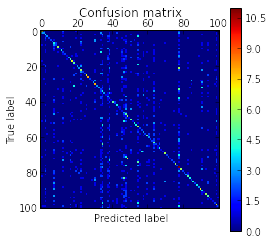

0.2110969387755102

In [456]:
# Create confusion matrix
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(normalized_data.true_label, normalized_data.predicted_label)

# Show confusion matrix in a separate window
plt.figure(figsize=(12, 12))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#Normalize scores to compute average precision for each class

In [457]:
print 'MAP: %2f'%np.mean(average_precision)

MAP: 0.319083


In [458]:
# What was the accuracy?
np.mean(normalized_data.true_label == normalized_data.predicted_label)

0.2110969387755102